<span style="font-size: 48px; font-weight: bold;">Algorytm BOGP testowany na zbiorze Fashion-MNIST</span>

Spis treści

- [1](#1)- Zainstalowanie wymaganych pakietów
- [2](#2) - Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow
- [3](#3) - Załadowanie danych
- [4](#4) - Ocena zbalansowania zbioru
- [5](#5) - Normalizacja danych
- [6](#6)- Zdefiniowanie CNN
- [7](#7) - Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście
- [8](#8) - Zdefiniowa funkcji celu
- [9](#9) - Zdefiniowanie parametrów startowych
- [10](#10) - Wykonanie proces optymalizacji bayesowskiej za pomocą funkcji `gp_minimize`
- [11](#11) - Wyświetlenie najlepszych wyników
- [12](#12) - Wykres konwergencji
- [13](#13) - Wykres wartość funkcji celu w każdej iteracji
- [14](#14) - Wykres plot_objective
- [15](#15) - Wykres plot evaluations
- [16](#16) - Macierz pomyłek
- [17](#17) - Ocena modelu na zbiorze testowym

### <a name='1'></a> 1. Zainstalowanie wymaganych pakietów

In [1]:
# !pip install scikit-learn
# !pip install scikit-optimize
# !pip install keras
# !pip install numpy

### <a name="2"></a> 2. Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow

In [2]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D,MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

import tensorflow as tf


In [3]:
import time


### <a name="3"></a> 3.Załadowanie danych


In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
type(y_train)

numpy.ndarray

### <a name="4"></a> 4.Ocena zbalansowania zbioru

Text(0, 0.5, 'Number of images')

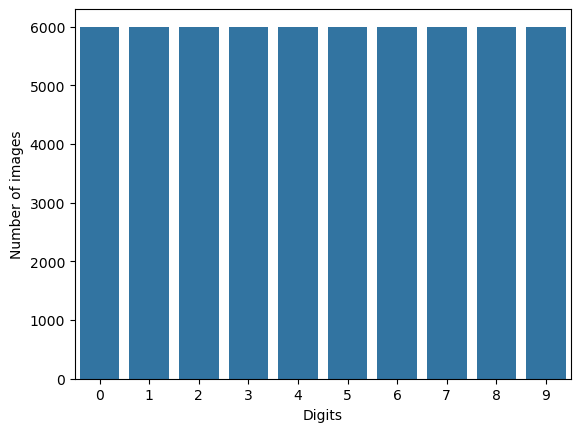

In [6]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

### <a name="5"></a> 5. Normalizacja danych

In [7]:
X_train = X_train / 255
X_test = X_test / 255

X_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
X_test = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
y_train = pd.DataFrame(y_train, columns=['label'])
y_test = pd.DataFrame(y_test, columns=['label'])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [8]:
type(X_train)

numpy.ndarray

### <a name="6"></a> 6.Zdefiniowanie CNN

In [9]:
def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hiperparametry:
    learning_rate: Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw gęstych.
    num_dense_nodes: Liczba neuronów w każdej warstwie gęstej.
    activation: Funkcja aktywacji dla wszystkich warstw.
    """

    model = Sequential()

    model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    

    model.add(Conv2D(kernel_size=5, strides=1, filters=64, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten()) 

    
    for i in range(num_dense_layers):

        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))


    model.add(Dense(10, activation='sigmoid')) 

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

### <a name="7"></a> 7.Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście

In [10]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

dim_num_dense_nodes = Integer(low=10, high=500, name='num_dense_nodes')


dim_activation = Categorical(
    categories=['relu', 'sigmoid'], name='activation',
)

param_grid = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

### <a name="8"></a> 8.Zdefiniowa funkcji celu

In [11]:
# model zapisany pod nazwą
path_best_model = 'cnn_model.h5'

# punkt startowy dla optymalizacji
best_accuracy = 0



@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
):

    """
    Hiperparametry:
    learning_rate:    Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw w pełni połączonych (dense).
    num_dense_nodes:  Liczba neuronów w każdej warstwie dense.
    activation:       Funkcja aktywacji dla wszystkich warstw.
    """

    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()

    model = create_cnn(learning_rate=learning_rate,
                       num_dense_layers=num_dense_layers,
                       num_dense_nodes=num_dense_nodes,
                       activation=activation)


    """
    Callback do redukcji współczynnika uczenia
    Automatycznie zmniejsza współczynnik uczenia (learning_rate) o factor=0.5, jeśli
    val_accuracy (dokładność na zbiorze walidacyjnym) nie poprawi się przez patience=2 epoki.
    Minimalny współczynnik uczenia to min_lr=0.00001."""
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)

    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=5,
                        batch_size=32,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    accuracy = history.history['val_accuracy'][-1]

    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy

    if accuracy > best_accuracy:
        model.save(path_best_model)

        best_accuracy = accuracy

    del model

    return -accuracy

### <a name="9 "></a> 9. Zdefiniowanie defaltowych parametrów

In [12]:
default_parameters = [1e-5, 1, 16, 'relu']

### <a name="10"></a> 10. Wykonujemy proces optymalizacji bayesowskiej za pomocą funkcji `gp_minimize`
gdzie:
- **Przekazujemy:**
  - Funkcję celu (objective function),
  - Przestrzeń hiperparametrów (hyperparameter space),
  - Początkowe parametry: `x0` (lista z początkowymi wartościami hiperparametrów),
  - Funkcję akwizycji (acquisition function): domyślnie `"EI"` (Expected Improvement).
  - Liczbę próbek przestrzeni hiperparametrów: `n_calls=30`,
  - zmienną random_state ustawioną na 0 w celu reprodukowalności wyników


- **Cel:**
  Znalezienie optymalnych wartości hiperparametrów minimalizujących funkcję celu.

Biblioteka **skopt** wymaga określonej liczby punktów początkowych, które mogą być generowane losowo lub zdefiniowane w parametrze `x0`. 

Oprócz tego optymalizator wymaga dodatkowych wywołań do wyznaczania nowych punktów w przestrzeni hiperparametrów. Minimalna liczba wywołań to `n_calls >= 11`.

In [13]:
start_time = time.perf_counter() 
gp_ = gp_minimize(
    objective, 
    param_grid, 
    x0=default_parameters, 
    acq_func='EI', 
    n_calls=100, 
    random_state=0,
)
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time} sekund")

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.2211 - loss: 0.4389 - val_accuracy: 0.5688 - val_loss: 0.2351 - learning_rate: 1.0000e-05
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6070 - loss: 0.2164 - val_accuracy: 0.6618 - val_loss: 0.1756 - learning_rate: 1.0000e-05
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6565 - loss: 0.1715 - val_accuracy: 0.6782 - val_loss: 0.1521 - learning_rate: 1.0000e-05
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6812 - loss: 0.1514 - val_accuracy: 0.7317 - val_loss: 0.1372 - learning_rate: 1.0000e-05
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7325 - loss: 0.1368 - val_accuracy: 0.7587 - val_loss: 0.1279 - learning_rate: 1.0000e-05



Accuracy: 75.87%

learning rate: 2.4e-04
num_dense_layers: 4
num_dense_nodes: 430
activation: sigmoid

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.0978 - loss: 0.3332 - val_accuracy: 0.1032 - val_loss: 0.3263 - learning_rate: 2.3517e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.1420 - loss: 0.3122 - val_accuracy: 0.7523 - val_loss: 0.1206 - learning_rate: 2.3517e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7506 - loss: 0.1150 - val_accuracy: 0.7995 - val_loss: 0.0944 - learning_rate: 2.3517e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8069 - loss: 0.0923 - val_accuracy: 0.8262 - val_loss: 0.0825 - learning_rate: 2.3517e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8275 - loss: 0.0831 - val_accuracy: 0.8238 - val_loss: 0.0803 - learning_rate: 2.3517e-04



Accuracy: 82.38%

learning rate: 3.1e-04
num_dense_layers: 3
num_dense_nodes: 156
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6745 - loss: 0.1566 - val_accuracy: 0.8570 - val_loss: 0.0697 - learning_rate: 3.1207e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8698 - loss: 0.0645 - val_accuracy: 0.8815 - val_loss: 0.0573 - learning_rate: 3.1207e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8904 - loss: 0.0544 - val_accuracy: 0.8912 - val_loss: 0.0537 - learning_rate: 3.1207e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9060 - loss: 0.0472 - val_accuracy: 0.9030 - val_loss: 0.0497 - learning_rate: 3.1207e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9171 - loss: 0.0413 - val_accuracy: 0.9027 - val_loss: 0.0470 - learning_rate: 3.1207e-04



Accuracy: 90.27%

learning rate: 1.2e-05
num_dense_layers: 3
num_dense_nodes: 408
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4500 - loss: 0.3122 - val_accuracy: 0.7485 - val_loss: 0.1207 - learning_rate: 1.2320e-05
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7562 - loss: 0.1186 - val_accuracy: 0.7847 - val_loss: 0.1027 - learning_rate: 1.2320e-05
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7897 - loss: 0.1025 - val_accuracy: 0.8052 - val_loss: 0.0947 - learning_rate: 1.2320e-05
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8078 - loss: 0.0942 - val_accuracy: 0.8212 - val_loss: 0.0885 - learning_rate: 1.2320e-05
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8172 - loss: 0.0887 - val_accuracy: 0.8283 - val_loss: 0.0850 - learning_rate: 1.2320e-05

Accuracy: 82.83%

learning rate: 3.7e-05
num_dense_layers: 4
num_dense_nodes: 175
activation: sigmoid

Epoch


Accuracy: 90.68%

learning rate: 7.9e-04
num_dense_layers: 5
num_dense_nodes: 500
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.7040 - loss: 0.1335 - val_accuracy: 0.8920 - val_loss: 0.0554 - learning_rate: 7.9447e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8968 - loss: 0.0522 - val_accuracy: 0.8948 - val_loss: 0.0545 - learning_rate: 7.9447e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9164 - loss: 0.0424 - val_accuracy: 0.9050 - val_loss: 0.0492 - learning_rate: 7.9447e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9267 - loss: 0.0369 - val_accuracy: 0.9140 - val_loss: 0.0484 - learning_rate: 7.9447e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9342 - loss: 0.0343 - val_accuracy: 0.9133 - val_loss: 0.0452 - learning_rate: 7.9447e-04



Accuracy: 91.33%

learning rate: 4.3e-03
num_dense_layers: 1
num_dense_nodes: 500
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7875 - loss: 0.1020 - val_accuracy: 0.8852 - val_loss: 0.0565 - learning_rate: 0.0043
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8952 - loss: 0.0519 - val_accuracy: 0.9028 - val_loss: 0.0504 - learning_rate: 0.0043
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9092 - loss: 0.0446 - val_accuracy: 0.9003 - val_loss: 0.0491 - learning_rate: 0.0043
Epoch 4/5
1687/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9213 - loss: 0.0398
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0021673254668712616.
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9213 - loss: 0.0398 - val_accuracy: 0.8997 - val_loss: 0.0554 - learning_rate: 0.0043
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9393 - loss: 0.0307 - val_accuracy: 0.9103 - val_loss: 0.0472 


Accuracy: 91.68%

learning rate: 2.1e-04
num_dense_layers: 2
num_dense_nodes: 500
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.7172 - loss: 0.1382 - val_accuracy: 0.8582 - val_loss: 0.0683 - learning_rate: 2.1129e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8754 - loss: 0.0622 - val_accuracy: 0.8870 - val_loss: 0.0555 - learning_rate: 2.1129e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8985 - loss: 0.0501 - val_accuracy: 0.8877 - val_loss: 0.0523 - learning_rate: 2.1129e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9112 - loss: 0.0441 - val_accuracy: 0.9000 - val_loss: 0.0486 - learning_rate: 2.1129e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9219 - loss: 0.0397 - val_accuracy: 0.9150 - val_loss: 0.0425 - learning_rate: 2.1129e-04

Accuracy: 91.50%

learning rate: 5.9e-05
num_dense_layers: 1
num_dense_nodes: 147
activation: relu

Epo


Accuracy: 92.37%

learning rate: 6.3e-04
num_dense_layers: 3
num_dense_nodes: 380
activation: relu

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7447 - loss: 0.1209 - val_accuracy: 0.8887 - val_loss: 0.0549 - learning_rate: 6.2946e-04
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8959 - loss: 0.0518 - val_accuracy: 0.9002 - val_loss: 0.0483 - learning_rate: 6.2946e-04
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9141 - loss: 0.0421 - val_accuracy: 0.9058 - val_loss: 0.0471 - learning_rate: 6.2946e-04
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9274 - loss: 0.0358 - val_accuracy: 0.9185 - val_loss: 0.0433 - learning_rate: 6.2946e-04
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9386 - loss: 0.0310 - val_accuracy: 0.9155 - val_loss: 0.0446 - learning_rate: 6.2946e-04

Accuracy: 91.55%

learning rate: 6.9e-04
num_dense_layers: 1
num_dense_nodes: 10
activation: relu

Epoch 1/5

c:\Users\Jacek\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.00015796137179099166, 4, 500, 'relu'] before, using random point [1.5617476573091754e-05, 4, 221, 'relu']
  warnings.warn(


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.4005 - loss: 0.3298 - val_accuracy: 0.7518 - val_loss: 0.1215 - learning_rate: 1.5617e-05
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7555 - loss: 0.1178 - val_accuracy: 0.7865 - val_loss: 0.1044 - learning_rate: 1.5617e-05
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7803 - loss: 0.1042 - val_accuracy: 0.7987 - val_loss: 0.0955 - learning_rate: 1.5617e-05
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8018 - loss: 0.0959 - val_accuracy: 0.8085 - val_loss: 0.0907 - learning_rate: 1.5617e-05
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8181 - loss: 0.0886 - val_accuracy: 0.8222 - val_loss: 0.0868 - learning_rate: 1.5617e-05

Accuracy: 82.22%

learning rate: 1.6e-04
num_dense_layers: 4
num_dense_nodes: 500
activation: sigmoid

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.0981 - loss: 0.3372 - val_accuracy: 0.0985 - va

### <a name="11"></a> 11. Wyświetlenie najlepszych wyników

- **Dokładność (accuracy):** wyświetlenie najlepszej osiągniętej dokładności.
- **Najlepsze hiperparametry:** wyświetlenie optymalnych wartości hiperparametrów.
- **Przestrzeń poszukiwań (gp_space):** analiza przestrzeni hiperparametrów.

In [14]:
"Najlepsza dokładność=%.4f" % gp_.fun

'Najlepsza dokładność=-0.9237'

In [15]:
print("""Najlepsze hiperparametry:
=========================
- learning rate=%.6f
- num_dense_layers=%d
- num_nodes=%d
- activation = %s""" % (gp_.x[0],
                gp_.x[1],
                gp_.x[2],
                gp_.x[3]))

Najlepsze hiperparametry:
- learning rate=0.000995
- num_dense_layers=1
- num_nodes=297
- activation = relu


In [16]:
gp_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Integer(low=1, high=5, prior='uniform', transform='normalize'),
       Integer(low=10, high=500, prior='uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid'), prior=None)])

### <a name="12"></a> 12. Wykres konwergencji




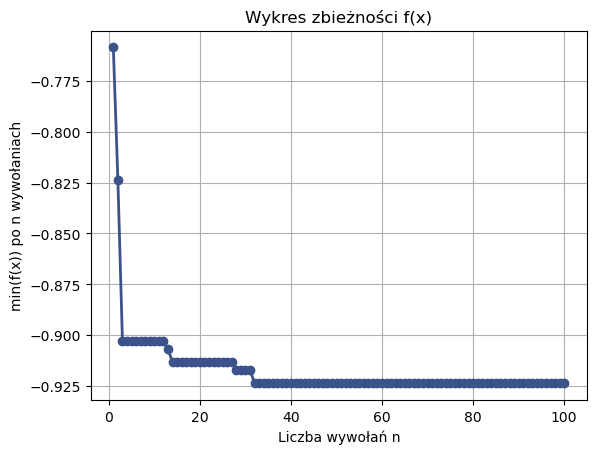

In [17]:
fig = plot_convergence(gp_)

plt.title("Wykres zbieżności f(x)")
plt.xlabel("Liczba wywołań n")
plt.ylabel("min(f(x)) po n wywołaniach")

fig.figure.savefig('wykres_zbieznosci.jpg', format='jpg', dpi=300)

plt.show()

In [18]:

iterations = range(len(gp_.func_vals))  
losses = gp_.func_vals               
cumulative_min = np.minimum.accumulate(losses) 

data_to_save = np.column_stack((iterations, losses, cumulative_min))

file_path = "convergence_data.txt"
np.savetxt(file_path, data_to_save, delimiter=',', header="Iteration,Loss,Cumulative_Min", fmt='%.6f', comments='')

print(f"Dane zapisano do pliku: {file_path}")

Dane zapisano do pliku: convergence_data.txt


### <a name="13"></a> 13. Wykres wartość funkcji celu w każdej iteracji

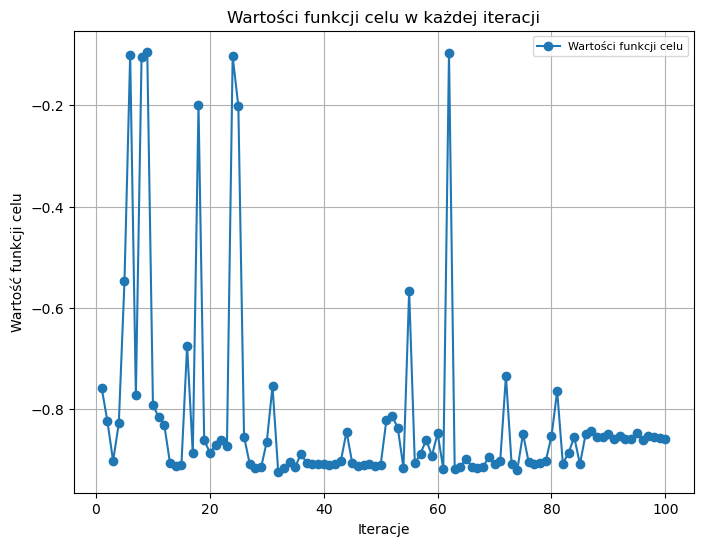

In [19]:

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(gp_.func_vals) + 1), gp_.func_vals, marker='o', label='Wartości funkcji celu')
plt.xlabel("Iteracje")
plt.ylabel("Wartość funkcji celu")
plt.title("Wartości funkcji celu w każdej iteracji")
plt.grid()
plt.legend(loc='upper right', fontsize=8)
plt.savefig('wyniki_funkcji_celu.png', dpi=300, bbox_inches='tight')

plt.show()

In [24]:

iterations = range(1, len(gp_.func_vals) + 1)  
losses = gp_.func_vals                         

data_to_save = np.column_stack((iterations, losses))

file_path = "function_values.txt"
np.savetxt(file_path, data_to_save, delimiter=',', header="Iteration,Loss", fmt='%d,%.6f', comments='')

print(f"Dane zapisano do pliku: {file_path}")

Dane zapisano do pliku: function_values.txt


### <a name="14"></a> 14.Wykres plot_objective

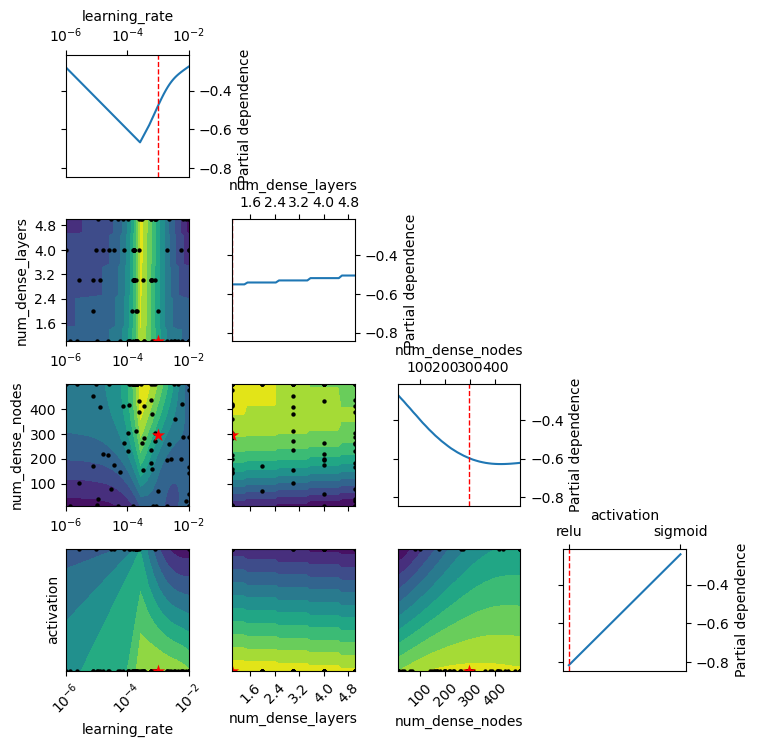

In [20]:
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'activation']
fig2=plot_objective(result=gp_, plot_dims=dim_names)
plt.show()
fig2.figure.savefig('plot_objective.jpg', format='jpg', dpi=300)



### <a name="15"></a> 15.Wykres plot evaluations

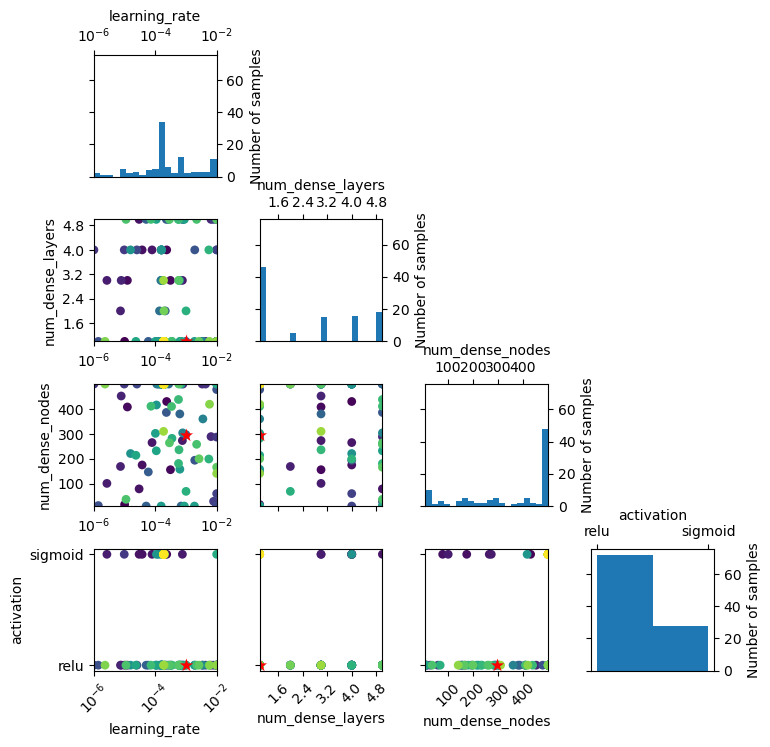

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [21]:
fig3=plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()
model = load_model('cnn_model.h5')
fig3.figure.savefig('plot_evaluations.jpg', format='jpg', dpi=300)
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis = 1)

y_true = np.argmax(y_test, axis = 1)

cm = confusion_matrix(y_true, y_pred_classes)



### <a name="16"></a> 16. Macierz pomyłek

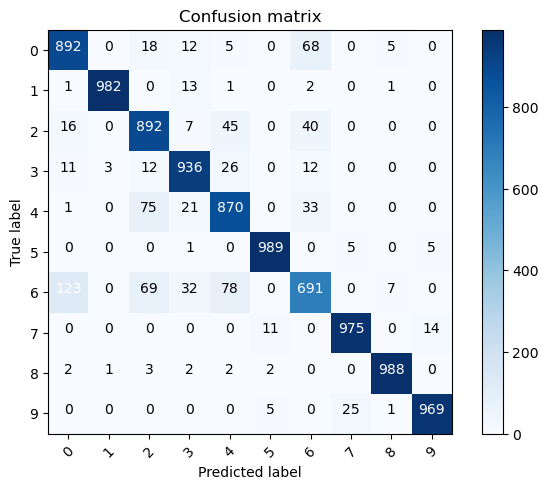

In [22]:

classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.jpg', format='jpg', dpi=300)

### <a name="17"></a> 17. Ocena modelu na zbiorze testowym

In [23]:
model = load_model('cnn_model.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9166 - loss: 0.0434
Test Loss: 0.04273494333028793
Test Accuracy: 0.91839998960495
